Heavily adapted from [this Kaggle notebook](https://www.kaggle.com/code/dschettler8845/visual-in-depth-eda-vinbigdata-competition-data)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch

device = torch.device('mps')

In [2]:
df_train = pd.read_csv("data/train.csv")
df_train.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN


In [3]:
df_train['class_id'].value_counts()

class_id
14    31818
0      7162
3      5427
11     4842
13     4655
8      2580
7      2483
10     2476
9      2203
6      1247
5      1000
2       960
4       556
1       279
12      226
Name: count, dtype: int64

### Total object annotations per image

Let's count the distribution of the amount of annotations per unique image_id value. Note that we use a log-axis for the count axis to handle the large number of values present at 3 annotations (a single object annotated similarily by 3 radiologists)

From the histogram plotted below we can see that:

- Images contain at least 3 annotations (1 distinct object annotation by 3 radiologists)
- Images contain at most 57 annotations (19 distinct object annotations by 3 radiologists)
- The vast majority of images only have 3 annotations (~11,000 out of 15,000 images)
- The distribution has a heavy skew. A perfectly symetrical distribution would have a skew value of 0.


/var/folders/q_/6hcy60n16fzdc67hkgkfst2r0000gn/T/ipykernel_35373/3113414201.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


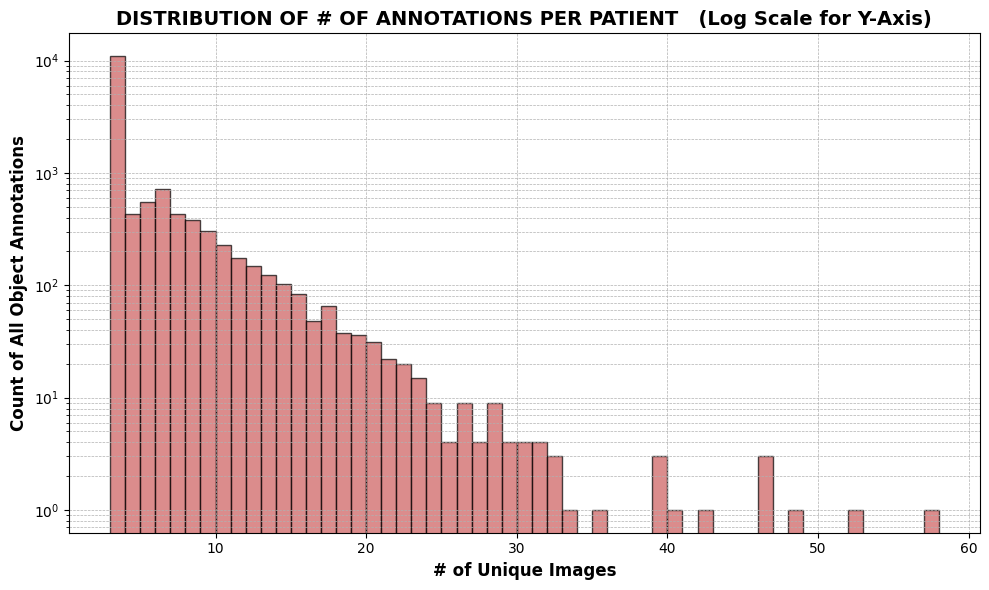

In [4]:
data = df_train.image_id.value_counts().values

# Create figure and plot
plt.figure(figsize=(10, 6))
plt.hist(data, bins=range(min(data), max(data) + 2), 
         color='indianred', alpha=0.7, edgecolor='black')
plt.yscale('log')

# Set title and labels with bold formatting
plt.title('DISTRIBUTION OF # OF ANNOTATIONS PER PATIENT   (Log Scale for Y-Axis)', 
          fontsize=14, fontweight='bold')
plt.xlabel('# of Unique Images', fontsize=12, fontweight='bold')
plt.ylabel('Count of All Object Annotations', fontsize=12, fontweight='bold')

plt.legend().set_visible(False)

# Add grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


### Unique object annotations per image

Let's count the distribution of UNIQUE object-label annotations per unique image_id value. This means if a radiologist identifies 8 nodules in an image, we count that as 1 unique object annotation. The goal of this is to determine the distributions of different diseases occuring within the same patient.

Note that we use a log-axis for the count axis to handle the large number of values present at 1 unique abnormality.

From the histogram plotted below we can ascertain the following information:

- Images contain no more than 10 unique abnormalities (out of a possible 14)
- The more unique abnormalities present in an image, the rarer it is.

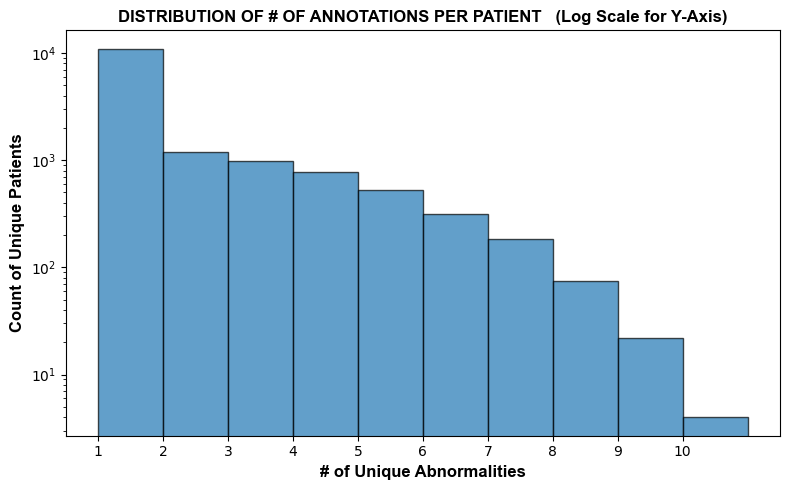

In [5]:
data = df_train.groupby('image_id')["class_name"].unique().apply(len)

# Define a font dictionary (assuming FIG_FONT is defined elsewhere)
FIG_FONT = {'family': 'Arial', 'size': 12, 'weight': 'bold'}

plt.figure(figsize=(8, 5))
plt.hist(data, bins=range(1, data.max()+2), 
         alpha=0.7, log=True, edgecolor='black')
plt.xlabel("# of Unique Abnormalities", fontdict=FIG_FONT)
plt.ylabel("Count of Unique Patients", fontdict=FIG_FONT)
plt.title("DISTRIBUTION OF # OF ANNOTATIONS PER PATIENT   (Log Scale for Y-Axis)", fontdict=FIG_FONT)
plt.xticks(range(1, data.max()+1))
plt.tight_layout()
plt.show()

### Annotations per class

We know there are 15 different possible class_names (including `No finding`). To identify the distribution of counts across the labels we will use a bar-chart.

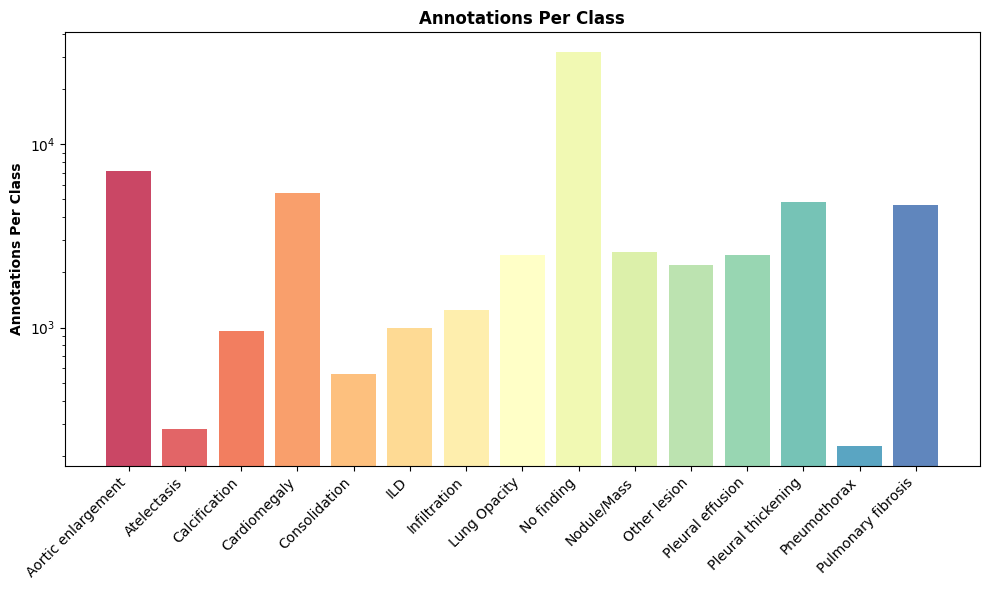

In [6]:
class_counts = df_train.class_name.value_counts().sort_index()

fig, ax = plt.subplots(figsize=(10, 6))
colors_class = sns.color_palette("Spectral", 15)

bars = ax.bar(class_counts.index, class_counts.values, 
              color=[colors_class[i % len(colors_class)] for i in range(len(class_counts))],
              alpha=0.85)

ax.set_yscale('log')

ax.set_xlabel('')
ax.set_ylabel('Annotations Per Class', fontweight='bold')
ax.set_title('Annotations Per Class', fontweight='bold')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Annotations per Radiologist

The rad_id column indicates the the ID of the radiologist that made the observation. Remember, three radiologists will annotate a given image out of a pool of seventeen possible radiologists, where the radiologist ID is encoded from R1 to R17.

We know there are 17 possible radiologists (rad_ids). To identify the distribution of annotations performed across the radiologists we will use a historgram.

From the histogram plotted below we can ascertain the following information

- 3 of the radiologists (R9, R10, & R8 in that order) are responsible for the vast majority of annotations (~40-50% of all annotations)
- Among the other 14 radiologists there is some variation around the number of annotations made, however, these 14 radiologists all made between 3121 annotations and 812 annotations with the vast majority annotating 1800-2200 objects.

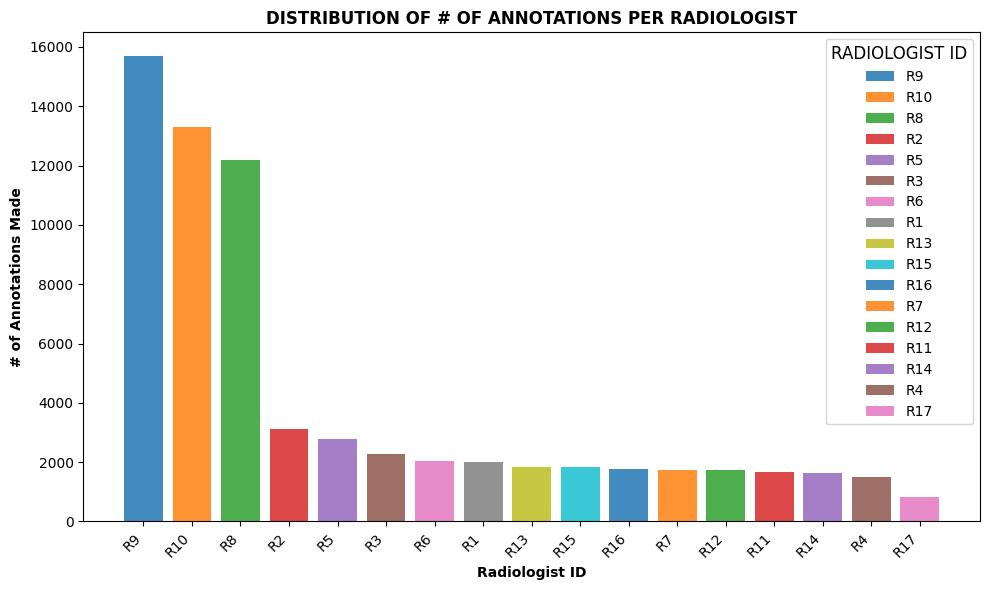

In [7]:
# Get the counts of annotations per radiologist and sort in descending order
rad_counts = df_train['rad_id'].value_counts().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))

colors_rad = sns.color_palette("tab10", len(rad_counts))

bars = ax.bar(rad_counts.index.astype(str), rad_counts.values, 
              color=colors_rad, alpha=0.85)

ax.set_xlabel('Radiologist ID', fontweight='bold')
ax.set_ylabel('# of Annotations Made', fontweight='bold')
ax.set_title('DISTRIBUTION OF # OF ANNOTATIONS PER RADIOLOGIST', fontweight='bold')

ax.legend(bars, rad_counts.index.astype(str), title='RADIOLOGIST ID', 
          title_fontsize='12', fontsize='10')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- The class_id column indicates the label encoded as a number the respective object/annotation (each row is for one object/annotation). 
- Knowing this, we will remove the previous class_name column, as we would rather work with a numeric representation. 
- Prior to removal we will generate a map that will allow us to translate the numeric labels back into their respective string represntations.

In [8]:
int_2_str = {i:df_train[df_train["class_id"]==i].iloc[0]["class_name"] for i in range(15)}
str_2_int = {v:k for k,v in int_2_str.items()}
int_2_clr = {str_2_int[k]:colors_class[i] for i,k in enumerate(sorted(str_2_int.keys()))}

print("Dictionary Mapping Class Integer to Class String Representation [int_2_str]:\n")
display(int_2_str)

print("Dictionary Mapping Class String to Class Integer Representation [str_2_int]:\n")
display(str_2_int)

print("Dictionary Mapping Class Integer to Color Representation [str_2_clr]:\n")
display(int_2_clr)

Dictionary Mapping Class Integer to Class String Representation [int_2_str]:



{0: 'Aortic enlargement',
 1: 'Atelectasis',
 2: 'Calcification',
 3: 'Cardiomegaly',
 4: 'Consolidation',
 5: 'ILD',
 6: 'Infiltration',
 7: 'Lung Opacity',
 8: 'Nodule/Mass',
 9: 'Other lesion',
 10: 'Pleural effusion',
 11: 'Pleural thickening',
 12: 'Pneumothorax',
 13: 'Pulmonary fibrosis',
 14: 'No finding'}

Dictionary Mapping Class String to Class Integer Representation [str_2_int]:



{'Aortic enlargement': 0,
 'Atelectasis': 1,
 'Calcification': 2,
 'Cardiomegaly': 3,
 'Consolidation': 4,
 'ILD': 5,
 'Infiltration': 6,
 'Lung Opacity': 7,
 'Nodule/Mass': 8,
 'Other lesion': 9,
 'Pleural effusion': 10,
 'Pleural thickening': 11,
 'Pneumothorax': 12,
 'Pulmonary fibrosis': 13,
 'No finding': 14}

Dictionary Mapping Class Integer to Color Representation [str_2_clr]:



{0: (0.7549404075355632, 0.15401768550557476, 0.29081122645136487),
 1: (0.8662821991541715, 0.2901191849288735, 0.2978085351787774),
 2: (0.942560553633218, 0.4057670126874279, 0.2682814302191465),
 3: (0.9748558246828143, 0.5574009996155325, 0.32272202998846594),
 4: (0.9926951172625913, 0.7092656670511341, 0.40299884659746243),
 5: (0.9951557093425606, 0.8322952710495963, 0.5063437139561706),
 6: (0.9976163014225298, 0.9261053440984237, 0.6250672818146866),
 7: (0.998077662437524, 0.9992310649750096, 0.7460207612456747),
 14: (0.9365628604382931, 0.9746251441753172, 0.6500576701268744),
 8: (0.8384467512495197, 0.9349480968858133, 0.6089965397923875),
 9: (0.6932718185313343, 0.8758938869665515, 0.6385236447520184),
 10: (0.5273356401384084, 0.8106113033448674, 0.6452133794694349),
 11: (0.3680123029603999, 0.7251057285659361, 0.6618223760092272),
 12: (0.24006151480199925, 0.58239138792772, 0.7208765859284891),
 13: (0.2671280276816609, 0.4412918108419839, 0.6975778546712803)}

### Annotations per radiologist separated by class label

We have already identified that three of the radiologists are responsible for almost 50% of all of the annotations. We would now like to identify if all of the radiologists were able to see and annotate all 15 classes. If so, can we identify any additional skew or problems that might arise?

From the first histogram plotted below we can see that:

- 3 of the radiologists (R9, R10, & R8 in that order) are responsible for the vast majority of annotations (~40-50% of all annotations)
- Among the other 11 radiologists there is some variation around the number of annotations made, however, these 11 radiologists all made between 3121 annotations and 812 annotations with the vast majority annotating 1800-2200 objects.

From the second histogram plotted below we can see that:

- Among the other 11 radiologists, 7 of them (R1 through R7) have only ever annotated images as No finding
- The other 4 radiologists are also heavily skewed towards the No finding label when compared to the main 3 radiologists (R8 through R10). This seems to actually be closer to the overall distribution, however it might allow us to estimate that radiologists other than R8, R9, and R10, are much more likely to annotate images as No finding.
- The downside to this distribution, is that if we include this information in the model than the model will learn that 7 of the radiologists classify images as No finding 100% of the time!

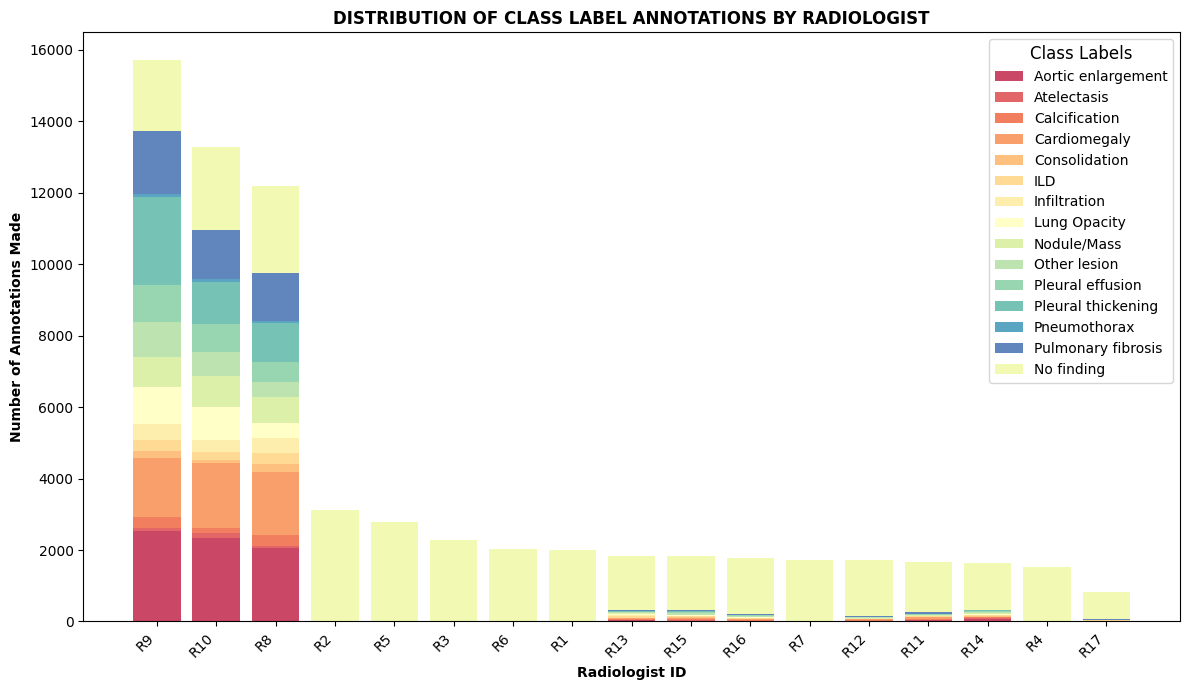

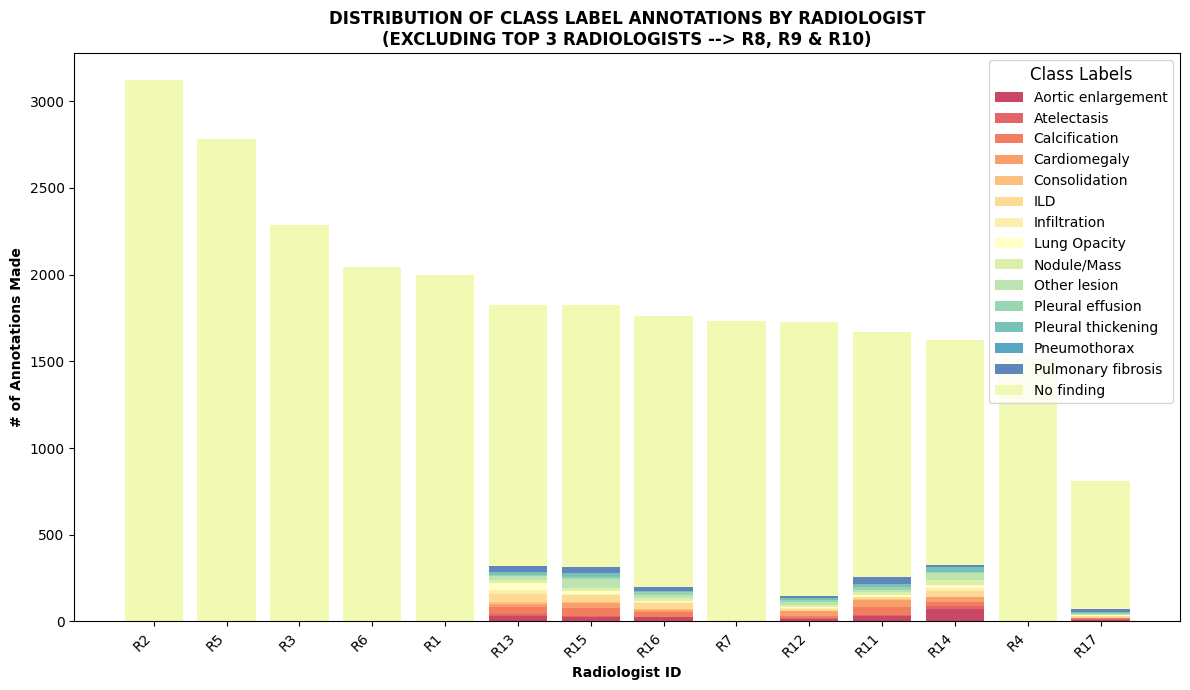

In [9]:
# First plot: All radiologists
# Prepare data for stacked bar chart: count of annotations per radiologist per class
class_ids = list(range(15))
radiologists_sorted = df_train['rad_id'].value_counts().index.tolist()  # sorted by total annotations

# Create a DataFrame with counts for each class and radiologist
counts = pd.DataFrame(0, index=radiologists_sorted, columns=class_ids)
for i in class_ids:
    class_data = df_train[df_train['class_id'] == i]['rad_id'].value_counts()
    for rad_id, count in class_data.items():
        counts.at[rad_id, i] = count

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(12, 7))

bottom = pd.Series(0, index=counts.index)

for i in class_ids:
    ax.bar(counts.index, counts[i], bottom=bottom, color=int_2_clr[i], label=int_2_str[i], alpha=0.85)
    bottom += counts[i]

# Set labels and title
ax.set_title('DISTRIBUTION OF CLASS LABEL ANNOTATIONS BY RADIOLOGIST', fontweight='bold')
ax.set_xlabel('Radiologist ID', fontweight='bold')
ax.set_ylabel('Number of Annotations Made', fontweight='bold')

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Add legend
ax.legend(title='Class Labels', title_fontsize='12', fontsize='10')

plt.tight_layout()
plt.show()

# Second plot: Excluding top 3 radiologists
# Filter out top 3 radiologists
excluded_rads = ["R8", "R9", "R10"]
train_df_filtered = df_train[~df_train['rad_id'].isin(excluded_rads)]

# Prepare data for stacked bar chart
radiologists_sorted_filtered = train_df_filtered['rad_id'].value_counts().index.tolist()

# Create a DataFrame with counts for each class and radiologist
counts_filtered = pd.DataFrame(0, index=radiologists_sorted_filtered, columns=class_ids)
for i in class_ids:
    class_data = train_df_filtered[train_df_filtered['class_id'] == i]['rad_id'].value_counts()
    for rad_id, count in class_data.items():
        counts_filtered.at[rad_id, i] = count

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(12, 7))

bottom = pd.Series(0, index=counts_filtered.index)

for i in class_ids:
    ax.bar(counts_filtered.index, counts_filtered[i], bottom=bottom, color=int_2_clr[i], label=int_2_str[i], alpha=0.85)
    bottom += counts_filtered[i]

# Set labels and title
title_text = 'DISTRIBUTION OF CLASS LABEL ANNOTATIONS BY RADIOLOGIST\n(EXCLUDING TOP 3 RADIOLOGISTS --> R8, R9 & R10)'
ax.set_title(title_text, fontweight='bold')
ax.set_xlabel('Radiologist ID', fontweight='bold')
ax.set_ylabel('# of Annotations Made', fontweight='bold')

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Add legend
ax.legend(title='Class Labels', title_fontsize='12', fontsize='10')

plt.tight_layout()
plt.show()

### Generating heatmaps of the overlapping bounding boxes

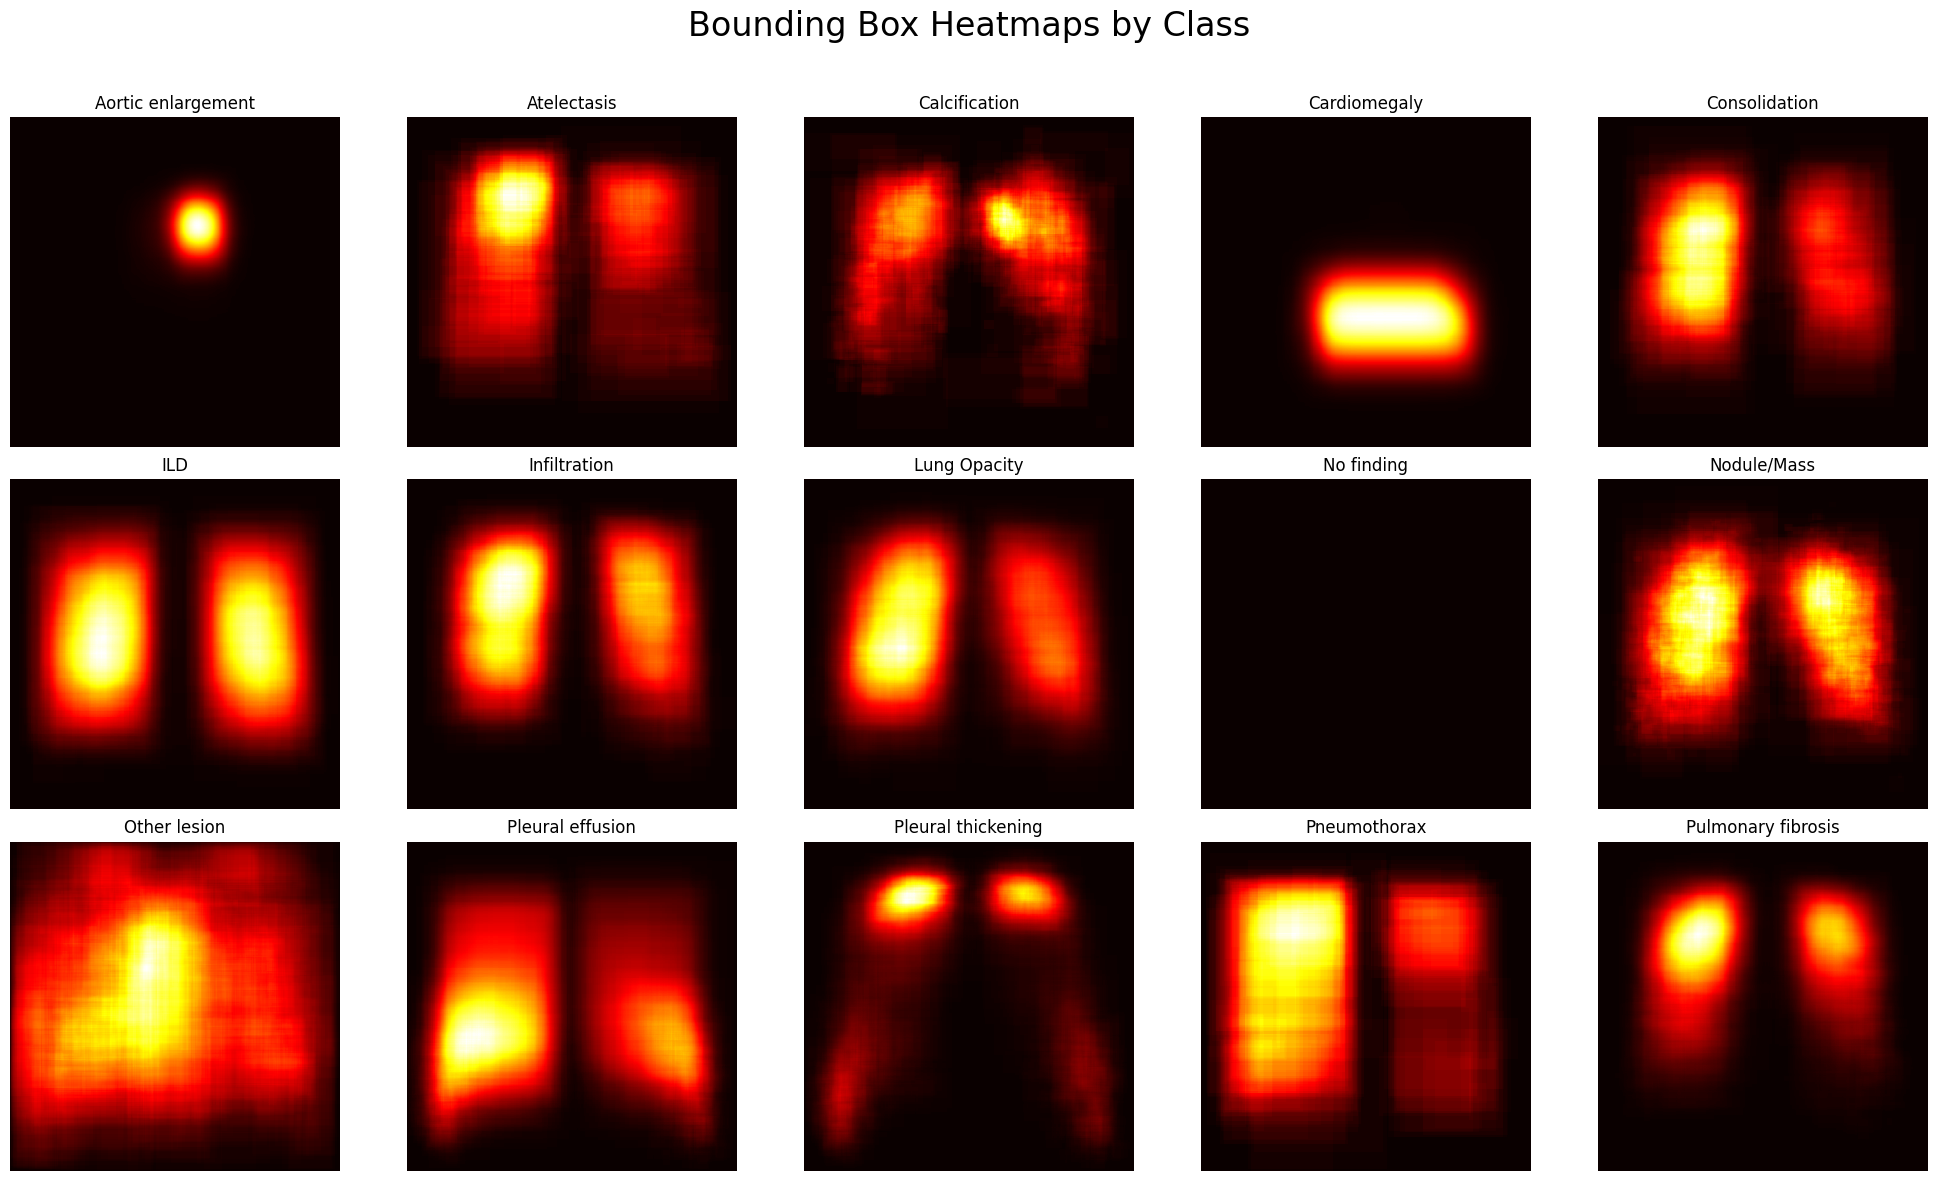

In [10]:
# Load your CSV data
df = pd.read_csv('data/scaled_bounding_boxes.csv')

# Set image dimensions (adjust as needed)
img_width, img_height = 1024, 1024

# Get unique class names (ensure they're sorted for consistent placement)
classes = sorted(df['class_name'].unique())

# Prepare the subplots: 3 rows x 5 columns
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()  # Flatten to easily iterate

for idx, class_name in enumerate(classes):
    heatmap = np.zeros((img_height, img_width))
    class_boxes = df[df['class_name'] == class_name]
    for _, row in class_boxes.iterrows():
        x_min = int(max(0, min(img_width-1, row['x_min'])))
        x_max = int(max(0, min(img_width-1, row['x_max'])))
        y_min = int(max(0, min(img_height-1, row['y_min'])))
        y_max = int(max(0, min(img_height-1, row['y_max'])))
        heatmap[y_min:y_max+1, x_min:x_max+1] += 1

    ax = axes[idx]
    im = ax.imshow(heatmap, cmap='hot', interpolation='nearest')
    ax.set_title(class_name)
    ax.axis('off')  # Hide axes for cleaner look

# Remove any unused subplots if classes < 15
for ax in axes[len(classes):]:
    ax.axis('off')

fig.suptitle('Bounding Box Heatmaps by Class', fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Combining and merging overlapping boxes (use NMS) (Work in Progress)